In [3]:
import re
import math
from gurobipy import *

In [17]:
# 数据读取类
class Data:
    def __init__(self):
        self.customerNum = 0
        self.nodeNum = 0
        self.vehicleNum = 0
        self.capacity = 0
        self.con_X = []
        self.con_Y = []
        self.demand = []
        self.readyTime = []
        self.dueTime = []
        self.serviceTime = []
        self.disMatrix = []

# 读取数据函数
def readData(data, path, customerNum):
    data.customerNum = customerNum
    data.nodeNum = customerNum + 2  #一个仓库起点和一个仓库终点
    f = open(path, 'r')
    lines = f.readlines()
    count = 0

    # 读取数据
    for line in lines:
        count = count + 1
        if count == 5:
            # 移除行尾换行符，# 去除首尾空白字符
            line = line[:-1].strip()
            # 按多个空格分割字符串（正则表达式" +"表示1个或多个空格）
            str = re.split(r" +", line)
            # 第一个值是车辆数（转换为整数）
            data.vehicleNum = int(str[0])
            # 第二个值是车辆容量（转换为浮点数）
            data.capacity = float(str[1])
        elif count >= 10 and count <= 10 + customerNum:#第一个坐标为仓库坐标
            line = line[:-1]
            str = re.split(r" +", line)
            # print(f"行内容: {str}")  # 打印分割后的列表
            # print(f"X坐标: {str[2]}, Y坐标: {str[3]}")  # 确认坐标位置
            data.con_X.append(float(str[2]))
            data.con_Y.append(float(str[3]))
            data.demand.append(float(str[4]))
            data.readyTime.append(float(str[5]))
            data.dueTime.append(float(str[6]))
            data.serviceTime.append(float(str[7]))
    
    # 添加最终返回得仓库节点（和第一个坐标相同）
    data.con_X.append(data.con_X[0])
    data.con_Y.append(data.con_Y[0])
    data.demand.append(data.demand[0])
    data.readyTime.append(data.readyTime[0])
    data.dueTime.append(data.dueTime[0])
    data.serviceTime.append(data.serviceTime[0])

    # 计算距离矩阵
    data.disMatrix = [[0] * data.nodeNum for _ in range(data.nodeNum)]
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            temp = (data.con_X[i] - data.con_X[j])**2 + (data.con_Y[i] - data.con_Y[j])**2
            data.disMatrix[i][j] = math.sqrt(temp)
    
    return data

# 数据初始化
data = Data()
path = 'solomon-100/In/c101.txt'  # 读取Solomon数据集
customerNum = 30   # 设置客户数量
readData(data, path, customerNum)
data.vehicleNum = 4  # 设置车辆数
BigM = 100000        # 定义一个极大值


In [25]:

# 创建模型
model = Model("VRPTW")

# 定义决策变量
x = {}  # 路径变量
s = {}  # 时间变量

for i in range(data.nodeNum):
    for k in range(data.vehicleNum):
        name = 's_' + str(i) + '_' + str(k)
        s[i,k] = model.addVar(lb=0, ub=1500, vtype=GRB.CONTINUOUS, name=name)#车辆k到达i地的时间
        for j in range(data.nodeNum):
            if i != j:
                name = 'x_' + str(i) + '_' + str(j) + '_' + str(k)
                x[i,j,k] = model.addVar(lb=0, ub=1, vtype=GRB.BINARY, name=name)#01变量 

# 设置目标函数
obj = LinExpr(0)
for i in range(data.nodeNum):
    for k in range(data.vehicleNum):
        for j in range(data.nodeNum):
            if i != j:
                obj.addTerms(data.disMatrix[i][j], x[i,j,k])
model.setObjective(obj, GRB.MINIMIZE)

# 约束一：车辆从仓库出发
for k in range(data.vehicleNum):
    lhs = LinExpr(0)
    for j in range(data.nodeNum):
        if j != 0:
            lhs.addTerms(1, x[0,j,k])
    model.addConstr(lhs == 1, name='vehicle_depart_' + str(k))

# 约束二：流量守恒
for k in range(data.vehicleNum):#对每辆车，去到每个顾客的流量等于从该顾客节点离开的流量（1）
    for h in range(1, data.nodeNum - 1):
        expr1 = LinExpr(0)
        expr2 = LinExpr(0)
        for i in range(data.nodeNum):
            if h != i:
                expr1.addTerms(1, x[i,h,k])
        for j in range(data.nodeNum):
            if h != j:
                expr2.addTerms(1, x[h,j,k])
        model.addConstr(expr1 == expr2, name='flow_conservation_' + str(h))
        expr1.clear()
        expr2.clear()

# 约束三：车辆返回仓库
for k in range(data.vehicleNum):
    lhs = LinExpr(0)
    for i in range(data.nodeNum - 1):
        if i != 0:
            lhs.addTerms(1, x[i, data.nodeNum-1, k])
    model.addConstr(lhs == 1, name='vehicle_enter_' + str(k))

# 约束四：客户被访问一次
for i in range(1, data.nodeNum - 1):
    lhs = LinExpr(0)
    for k in range(data.vehicleNum):
        for j in range(1, data.nodeNum):
            if i != j:
                lhs.addTerms(1, x[i,j,k])
    model.addConstr(lhs == 1, name='customer_visit_' + str(i))

# 约束五：时间窗约束
for k in range(data.vehicleNum):
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            if i != j:
                model.addConstr(
                    s[i,k] + data.disMatrix[i][j] + data.serviceTime[i] - s[j,k] <= BigM * (1 - x[i,j,k]),
                    name='time_window_' + str(i) + '_' + str(j) + '_' + str(k)
                )

# 约束六：准备时间和截止时间
for i in range(1, data.nodeNum - 1):
    for k in range(data.vehicleNum):
        model.addConstr(data.readyTime[i] <= s[i,k], name='ready_time_' + str(i))
        model.addConstr(s[i,k] <= data.dueTime[i], name='due_time_' + str(i))

# 约束七：车辆容量限制
for k in range(data.vehicleNum):
    lhs = LinExpr(0)
    for i in range(1, data.nodeNum - 1):
        for j in range(data.nodeNum):
            if i != j:
                lhs.addTerms(data.demand[i], x[i,j,k])
    model.addConstr(lhs <= data.capacity, name='capacity_vehicle_' + str(k))

# 求解模型
model.setParam('CoverCuts',2)
model.setParam(GRB.Param.LogFile,'gurobi_cut.log')
model.optimize()



Set parameter CoverCuts to value 2
Set parameter LogFile to value "gurobi_cut.log"
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845H w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
CoverCuts  2

Optimize a model with 4370 rows, 4096 columns and 27148 nonzeros
Model fingerprint: 0x93a400f5
Variable types: 128 continuous, 3968 integer (3968 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 4e+01]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 1e+05]
Presolve removed 3336 rows and 1944 columns
Presolve time: 0.08s
Presolved: 1034 rows, 2152 columns, 18096 nonzeros
Variable types: 128 continuous, 2024 integer (2024 binary)

Root relaxation: objective 2.261765e+02, 286 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objec

In [20]:
# 输出结果
print("\n\n---optimal value---")
print(model.ObjVal)

for key in x.keys():
    if x[key].x > 0:
        print(x[key].VarName + ' = ', x[key].x)

# 导出模型
model.write('VRPTW.lp')



---optimal value---
226.1765303670009
x_0_20_0 =  1.0
x_0_13_1 =  1.0
x_0_24_2 =  1.0
x_0_5_3 =  1.0
x_1_31_3 =  1.0
x_2_1_3 =  1.0
x_3_7_3 =  1.0
x_4_2_3 =  1.0
x_5_3_3 =  1.0
x_6_4_3 =  1.0
x_7_8_3 =  1.0
x_8_10_3 =  1.0
x_9_6_3 =  1.0
x_10_11_3 =  1.0
x_11_9_3 =  1.0
x_12_31_1 =  1.0
x_13_17_1 =  1.0
x_14_12_1 =  1.0
x_15_16_1 =  1.0
x_16_14_1 =  1.0
x_17_18_1 =  1.0
x_18_19_1 =  1.0
x_19_15_1 =  1.0
x_20_31_0 =  1.0
x_21_31_2 =  1.0
x_22_21_2 =  1.0
x_23_22_2 =  1.0
x_24_25_2 =  1.0
x_25_27_2 =  1.0
x_26_23_2 =  1.0
x_27_29_2 =  1.0
x_28_26_2 =  1.0
x_29_30_2 =  1.0
x_30_28_2 =  1.0


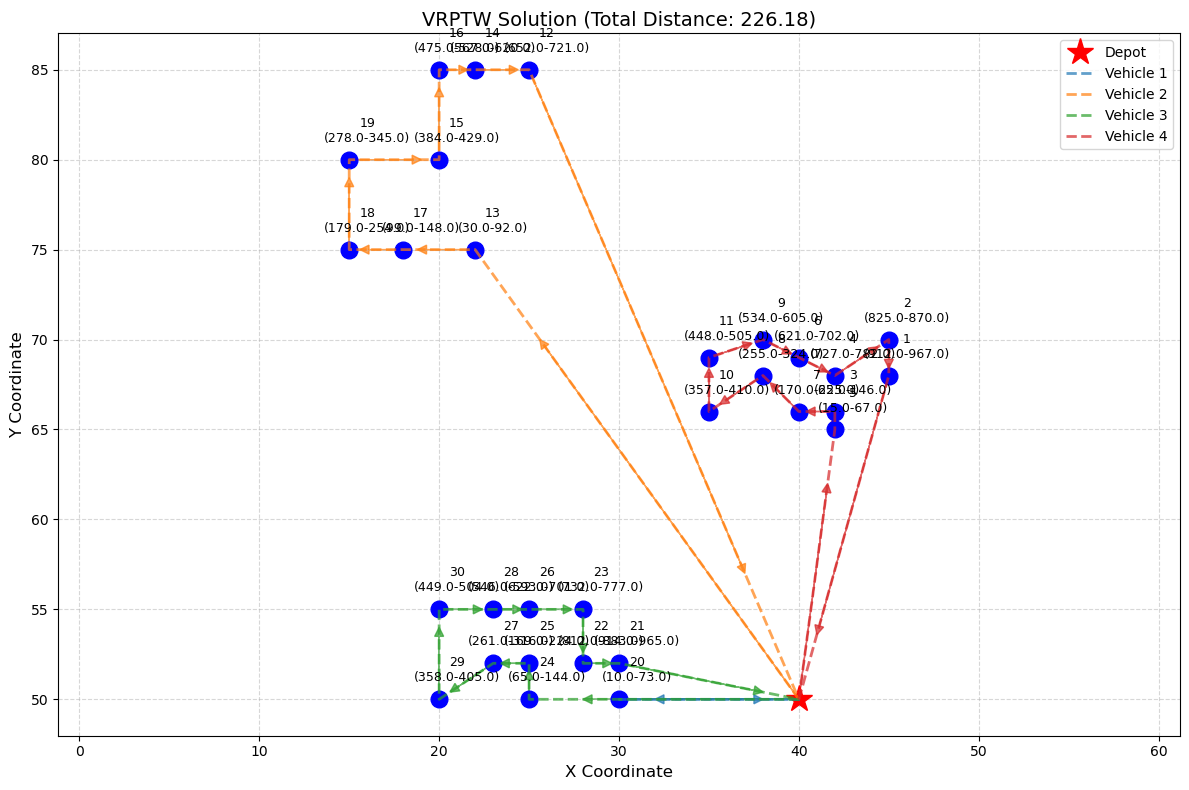

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

def visualize_vrptw_solution(data, model, x):
    # 提取激活的路径
    active_arcs = [(i,j,k) for (i,j,k) in x.keys() if x[i,j,k].x > 0.9]
    
    # 按车辆分组路径
    vehicle_routes = {}
    for k in range(data.vehicleNum):
        # 找到每辆车的起始弧(0,j,k)
        start_arcs = [(i,j,kk) for (i,j,kk) in active_arcs 
                      if i == 0 and kk == k]
        if not start_arcs:
            continue
            
        route = [0]  # 从仓库(0)出发
        current = 0
        while True:
            next_node = None
            for (i,j,kk) in active_arcs:
                if i == current and kk == k:
                    next_node = j
                    break
                    
            if next_node is None or next_node == data.nodeNum-1:  # 回到仓库终点
                route.append(0)
                break
                
            route.append(next_node)
            current = next_node
            
        vehicle_routes[k] = route
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 绘制仓库节点（红色五角星）
    plt.plot(data.con_X[0], data.con_Y[0], 'r*', markersize=20, label='Depot')
    
    # 绘制客户节点（蓝色圆圈）
    for i in range(1, data.nodeNum-1):
        plt.plot(data.con_X[i], data.con_Y[i], 'bo', markersize=12)
        plt.text(data.con_X[i]+1, data.con_Y[i]+1, 
                f'{i}\n({data.readyTime[i]}-{data.dueTime[i]})',
                fontsize=9, ha='center')
    
    # 颜色循环
    colors = plt.cm.tab10.colors
    
    # 绘制每辆车的路径
    for k, route in vehicle_routes.items():
        color = colors[k % len(colors)]
        
        # 获取路径坐标
        x_coords = [data.con_X[i] for i in route]
        y_coords = [data.con_Y[i] for i in route]
        
        # 绘制路径线
        line = plt.plot(x_coords, y_coords, '--', color=color, 
                       linewidth=2, alpha=0.7,
                       label=f'Vehicle {k+1}')[0]
        
        # 添加方向箭头
        for i in range(len(route)-1):
            start = route[i], route[i+1]
            dx = data.con_X[start[1]] - data.con_X[start[0]]
            dy = data.con_Y[start[1]] - data.con_Y[start[0]]
            
            plt.arrow(data.con_X[start[0]], data.con_Y[start[0]], 
                     dx*0.8, dy*0.8, 
                     shape='full', color=color,
                     length_includes_head=True, 
                     head_width=0.5, head_length=0.5,
                     alpha=0.7)
    
    # 添加图例和标题
    plt.title(f'VRPTW Solution (Total Distance: {model.ObjVal:.2f})', fontsize=14)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 设置等比例坐标轴
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# 使用示例（在model.optimize()之后调用）
visualize_vrptw_solution(data, model, x)